<a href="https://colab.research.google.com/github/Aron9605/Quantum-repetition-code/blob/main/phase_flip_optimal_code_length.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Break-even point of the quantum repetition code

---

In this notebook, using numpy, we investigate when the phase-flip repetition code is getting more advantageous than a single physical qubit against a certain noise model.

We study the repetition code under realistic noise models such as relaxation (T_1) and dephasing (T_2). The density matrix time-evolution is described by Kraus formalism.

We derive a break-even point, above which the repetition code is  effective and preserves arbitrary quantum data even longer than a single qubit lifetime. The optimal code-length is plotted as a function of the model parameters.


In [58]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sy
from numpy.linalg import multi_dot

%matplotlib inline

## Idle single physical qubit

In [59]:
#----------------------------------------------------------------------
##  BLOCK OF FUNCTIONS USED IN THE MAIN CODE
#----------------------------------------------------------------------

def psi_init(th, phi):
    'arbitrary initial state'
    return np.array([np.cos(th/2), np.sin(th/2)*np.exp(1j*phi)])

def rho_init(th, phi):
    'belonging density matrix'  
    return np.outer(psi_init(th, phi), np.conjugate(psi_init(th, phi)))

# Kraus-channel of amplitude and phase damping 
def error_channel(rho, t, T1, T2s):
    'time evolution of density matrix that contains the effect of noises'
    K1phase = np.array([[np.sqrt(np.exp(-2*t/T2s)),0],[0,np.sqrt(np.exp(-t/T1))]])
    K2phase = np.array([[np.sqrt(1-np.exp(-2*t/T2s)),0],[0,0]])
    K2relax = np.array([[0,np.sqrt(1-np.exp(-t/T1))],[0,0]])
    Kraus_list = np.array([K1phase, K2phase, K2relax])
    rho_t = np.zeros((2, 2))
    for i in Kraus_list:
        rho_t = np.add(np.linalg.multi_dot([i, rho, np.matrix.getH(i)]), rho_t)  
    return(rho_t)

def idling(th, phi, t, T1, T2s):
    return error_channel(rho_init(th, phi), t, T1, T2s)

#def fidelity(th, phi,  t, T1, T2s):
#    'averaged fidelity = integrate the state over the bloch spehere'
#    return 1/(4*np.pi)*np.linalg.multi_dot([np.conjugate(psi_init(th, phi)), idling(th, phi, t, T1, T2s), psi_init(th, phi)*np.sin(th)])

def fidelity_bloch_points(t, T1, T2s):
    'averaged fidelity = calculated in 6 cardinal points of Bloch sphere'
    f1 = np.linalg.multi_dot([np.conjugate(psi_init(0, 2*np.pi)), idling(0, 2*np.pi, t, T1, T2s), psi_init(0, 2*np.pi)])
    f2 = np.linalg.multi_dot([np.conjugate(psi_init(np.pi, 0)), idling(np.pi, 0, t, T1, T2s), psi_init(np.pi, 0)])
    f3 = np.linalg.multi_dot([np.conjugate(psi_init(np.pi/2, np.pi)), idling(np.pi/2, np.pi, t, T1, T2s), psi_init(np.pi/2, np.pi)])
    f4 = np.linalg.multi_dot([np.conjugate(psi_init(np.pi/2, 0)), idling(np.pi/2, 0, t, T1, T2s), psi_init(np.pi/2, 0)])
    f5 = np.linalg.multi_dot([np.conjugate(psi_init(np.pi/2, np.pi/2)), idling(np.pi/2, np.pi/2, t, T1, T2s), psi_init(np.pi/2, np.pi/2)])
    f6 = np.linalg.multi_dot([np.conjugate(psi_init(np.pi/2, -1*np.pi/2)), idling(np.pi/2, -1*np.pi/2, t, T1, T2s), psi_init(np.pi/2, -1*np.pi/2)])
    return (f1 + f2 + f3 + f4 + f5 + f6)/6

def chop(expr, delta=10**-10):
    if isinstance(expr, (int, float, complex)):
        return 0 if -delta <= expr <= delta else expr
    else:
        return [chop(x) for x in expr]

In [60]:
fid_idle = []
for t in range(0, 30):
    fid_idle.append(fidelity_bloch_points(t, 100, 10))

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


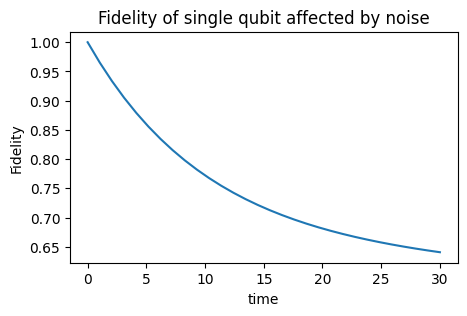

In [61]:
t_vals = np.linspace(0, 30, 30)
f_vals = fid_idle

plt.figure(figsize=(5,3))
plt.plot(t_vals, f_vals)
plt.ylabel("Fidelity")
plt.xlabel("time")
plt.title("Fidelity of single qubit affected by noise")
plt.show()

## 3-qubit phase-flip repetition code

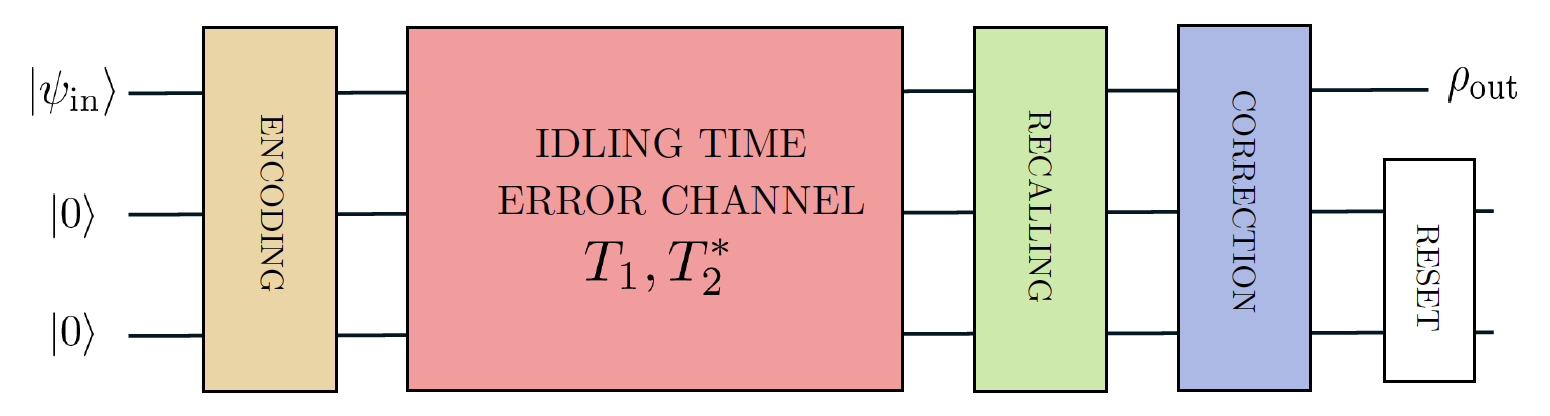

In [62]:
# Define CNOT matrix - CNOT(index-of-control-qubit, index-of-target-qubit)

N = 3
basis = [[i, j, k] for i in range(2) for j in range(2) for k in range(2)]

def CNOTket(i, j, lst):
    output = list(lst)
    if lst[i] == 0:
        return output
    else:
        output[j] = 1 - output[j]
        return output
    
def CNOT(i,j):
    mtx = np.zeros((2**N, 2**N))
    pos = []
    for n in range(len(basis)):
        pos.append([n, basis.index(CNOTket(i,j,basis[n]))])
    for i, j in pos:
        mtx[i][j] = 1
    return(mtx)

# Define Toffolo-gate -- TOFF(index-of-control-qubit1, index-of-control-qubit2, index-of-target-qubit)

def TOFket(i, j, k, lst):
    out = list(lst)
    if lst[i] == 0 or lst[j] == 0:
        return out
    else:
        out[k] = 1 - out[k]
        return out

def TOFF(i, j, k):
    mtx = np.zeros((2**N, 2**N))
    pos = []
    for n in range(len(basis)):
        pos.append([n, basis.index(TOFket(i,j,k,basis[n]))])
    for i, j in pos:
        mtx[i][j] = 1
    return(mtx)

# Hadamard gate
h = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
had = np.kron(h, np.kron(h,h)) # 3qubit operator

In [63]:
# Kraus-channel of amplitude and phase damping 
def error_channel_3qubit(rho, t, T1, T2s):
    'time-evoluiton of 3-qubit density matrix described by Kraus operators acting on each qubits independently'
    K1phase = np.array([[np.sqrt(np.exp(-2*t/T2s)),0],[0,np.sqrt(np.exp(-t/T1))]])
    K2phase = np.array([[np.sqrt(1-np.exp(-2*t/T2s)),0],[0,0]])
    K2relax = np.array([[0,np.sqrt(1-np.exp(-t/T1))],[0,0]])
    Kraus_list = np.array([K1phase, K2phase, K2relax])
    rho_t = np.zeros((8, 8))
    for i in Kraus_list:
        for j in Kraus_list:
            for k in Kraus_list:
                rho_t = np.add(np.linalg.multi_dot([np.kron(i, np.kron(j, k)), rho, np.matrix.getH(np.kron(i, np.kron(j, k)))]), rho_t) 
    return(rho_t)

def phase_flip_code(rho, t, T1, T2s):
    'initial 3-qubit denisty matrix'
    rho_0 = np.kron(rho, np.kron(rho_init(0, 2*np.pi), rho_init(0, 2*np.pi)))
    'encoding the arbitrary quantum information into 3-qubit state by cnot gates'
    rho_enc = np.linalg.multi_dot([CNOT(0,2), CNOT(0,1), rho_0, CNOT(0,1), CNOT(0,2)])
    'applying Hadamards on each qubits'
    rho_H = np.linalg.multi_dot([had, rho_enc, had])
    'idling time while errors corrupt the encoded state'
    rho_er = error_channel_3qubit(rho_H, t, T1, T2s)
    'applying Hadamards on each qubits'
    rho_Hinv = np.linalg.multi_dot([had, rho_er, had])
    'recalling the information into 1 qubit state and using the states of the remaining qubits as syndromes for error correction'
    rho_recall = np.linalg.multi_dot([CNOT(0,2), CNOT(0,1), rho_Hinv, CNOT(0,1), CNOT(0,2)])
    'Toffoli gate performs error correction'
    rho_cor = np.linalg.multi_dot([TOFF(1,2,0), rho_recall, np.matrix.getH(TOFF(1,2,0))])
    'traceing out the ancillary qubits'
    rho_traced = np.trace(np.trace(rho_cor.reshape([2,2,2,2,2,2]), axis1=1, axis2=4), axis1=1, axis2=3) #partial trace of q2(m,m) and q3(k,k); shape(n,m,k,n,m,k)
    return(rho_traced)

def idling_3qubit(th, phi, t, T1, T2s):
    return phase_flip_code(rho_init(th, phi), t, T1, T2s)

def fidelity_3qubit(t, T1, T2s):
    'averaged fidelity = calculated in 6 cardinal points of Bloch sphere'
    f1 = np.linalg.multi_dot([np.conjugate(psi_init(0, 2*np.pi)), idling_3qubit(0, 2*np.pi, t, T1, T2s), psi_init(0, 2*np.pi)])
    f2 = np.linalg.multi_dot([np.conjugate(psi_init(np.pi, 0)), idling_3qubit(np.pi, 0, t, T1, T2s), psi_init(np.pi, 0)])
    f3 = np.linalg.multi_dot([np.conjugate(psi_init(np.pi/2, np.pi)), idling_3qubit(np.pi/2, np.pi, t, T1, T2s), psi_init(np.pi/2, np.pi)])
    f4 = np.linalg.multi_dot([np.conjugate(psi_init(np.pi/2, 0)), idling_3qubit(np.pi/2, 0, t, T1, T2s), psi_init(np.pi/2, 0)])
    f5 = np.linalg.multi_dot([np.conjugate(psi_init(np.pi/2, np.pi/2)), idling_3qubit(np.pi/2, np.pi/2, t, T1, T2s), psi_init(np.pi/2, np.pi/2)])
    f6 = np.linalg.multi_dot([np.conjugate(psi_init(np.pi/2, -1*np.pi/2)), idling_3qubit(np.pi/2, -1*np.pi/2, t, T1, T2s), psi_init(np.pi/2, -1*np.pi/2)])
    return (f1 + f2 + f3 + f4 + f5 + f6)/6

In [64]:
fid_phase = []
for t in range(0, 30):
    fid_phase.append(fidelity_3qubit(t, 100, 10))

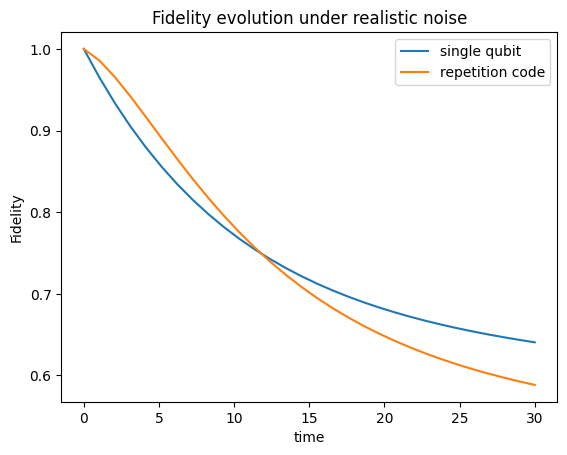

In [65]:
'''plotting a specific scenario when repetition code is beneficial (T1>2T2*) up to a treshold t time'''

t_vals = np.linspace(0, 30, 30)
f_vals3 = fid_phase

plt.plot(t_vals, f_vals)
plt.plot(t_vals, f_vals3)
plt.ylabel("Fidelity")
plt.xlabel("time")
plt.legend(['single qubit', 'repetition code'])
plt.title("Fidelity evolution under realistic noise")
plt.show()

## Breakeven point of 3-qubit code

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:601: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


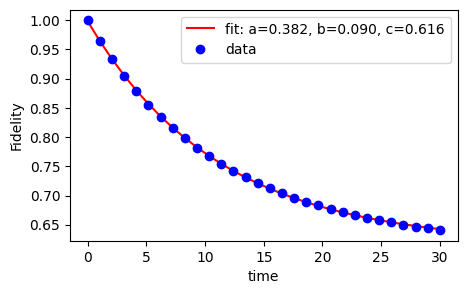

In [66]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(func, t_vals, f_vals)

plt.figure(figsize=(5,3))
plt.plot(t_vals, func(t_vals, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(t_vals, f_vals, 'b o', label='data')
plt.ylabel("Fidelity")
plt.xlabel("time")
plt.legend()#['single qubit - fit data', 'single qubit - data']
plt.show()

<ipython-input-67-636f428481ec>:4: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  p0 = sy.array([0.38, 0.09, 0.6, 0.1, 0.3])


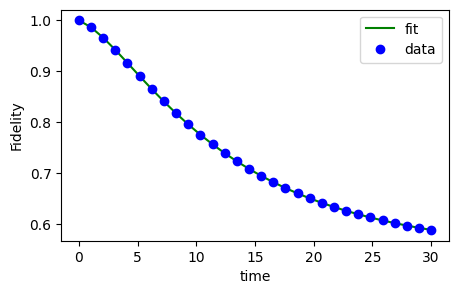

In [67]:
def func3(x, a, b, c, d, e):
    return a * np.exp(-1*b * x) + d * np.exp(-1*e * x) + c

p0 = sy.array([0.38, 0.09, 0.6, 0.1, 0.3])

popt3, pcov3 = curve_fit(func3, t_vals, f_vals3, p0)

plt.figure(figsize=(5,3))
plt.plot(t_vals, func3(t_vals, *popt3), 'g-')
plt.plot(t_vals, f_vals3, 'b o', label='data')
plt.ylabel("Fidelity")
plt.xlabel("time")
plt.legend(['fit', 'data'])
plt.show()

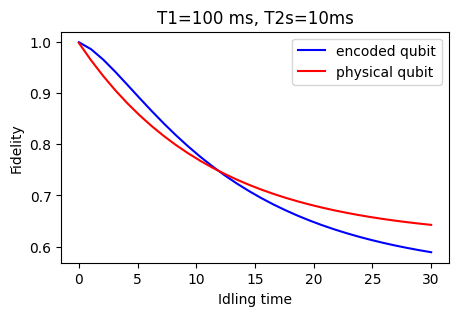

In [68]:
plt.figure(figsize=(5,3))
plt.plot(t_vals, func3(t_vals, *popt3), 'b-')
plt.plot(t_vals, func(t_vals, *popt), 'r-')
plt.ylabel("Fidelity")
plt.xlabel("Idling time")
plt.legend(['encoded qubit', 'physical qubit'])
plt.title('T1=100 ms, T2s=10ms')
plt.show()

In [69]:
idx = np.argwhere(np.diff(np.sign(func3(t_vals, *popt3) - func(t_vals, *popt)))).flatten()
print(idx)

[11]


In [70]:
print('Break-even point is at t =', t_vals[idx], 'ms.' )
print('Fidelity at break-even point:', func(t_vals, *[popt[0], popt[1], popt[2]])[idx])

Break-even point is at t = [11.37931034] ms.
Fidelity at break-even point: [0.75432192]


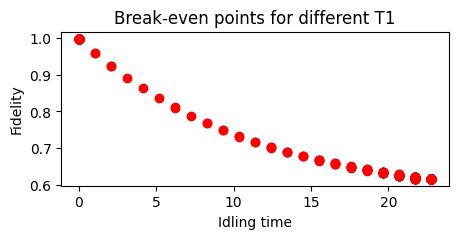

In [15]:
plt.figure(figsize=(5,2))
plt.ylabel("Fidelity")
plt.xlabel("Idling time")
plt.title('Break-even points for different T1')
for i in np.arange(0.0, 0.5, 0.001):
  idx = np.argwhere(np.diff(np.sign(func3(t_vals, *[popt3[0], popt[1], popt3[2], popt3[3], i]) - func(t_vals, *[popt[0], i, popt[2]])))).flatten()
  #plt.plot(t_vals, func(t_vals, *[popt[0], i, popt[2]]), '--')
  #plt.plot(t_vals, func3(t_vals, *[popt3[0], popt[1], popt3[2], popt3[3], i]))
  plt.plot(t_vals[idx], func(t_vals, *[popt[0], i, popt[2]])[idx], 'ro')
  #plt.plot(t_vals[idx], i, 'bo')


## Optimal code-length of phase-flip code

In [24]:
import math
from scipy.special import hyp2f1
from scipy.special import binom

def fid_n_dimT2(i, T1, t):
    'fidelity formula for arbitrary code-length i'
    term1 = 1/3 * (2 + (math.exp(-t/T1))**i)
    
    term2 = -((2**(-i) * math.exp(t + t/(2*T1)) * (1 - math.exp(-t*(2 + 1/T1)))**((1 + i)/2) * hyp2f1(1, (1 - i)/2, (3 + i)/2, (1 - math.exp(t + t/(2*T1)))/(1 + math.exp(t + t/(2*T1)))) / (3 * (1 + math.exp(t + t/(2*T1))))))
    
    term3 = -(2**(-i) * math.exp(t + t/T1) * (-math.exp(-t - t/(2*T1)) + math.exp(-t/T1))**((1 + i)/2) * (math.exp(-t - t/(2*T1)) + math.exp(-t/T1))**((1 + i)/2) * hyp2f1(1, (1 - i)/2, (3 + i)/2, (-math.exp(t) + math.exp(t/(2*T1)))/(math.exp(t) + math.exp(t/(2*T1))))) / (3 * (math.exp(t) + math.exp(t/(2*T1))))
    
    return term1 + binom(i, (1 + i)//2) * (term2 + term3)


In [42]:
def optimum(n, T1, t):
  'find the code-length corresponds to the highest fidelity'
  'code-length increases by 2; N = 1-3-5-7-9...'
  opt = []
  for i in range(1, n, 2):
    opt.append(fid_n_dimT2(i, T1, t))
  max_value = max(opt)
  max_index = opt.index(max_value)
  return max_index*2+1

In [43]:
T1ran=np.logspace(0,2,350)
tran=np.linspace(0,2,400)
N=13
DAT=np.array([optimum(N,T1,t) for t in tran for T1 in T1ran])
DAT=DAT.reshape(400,350)

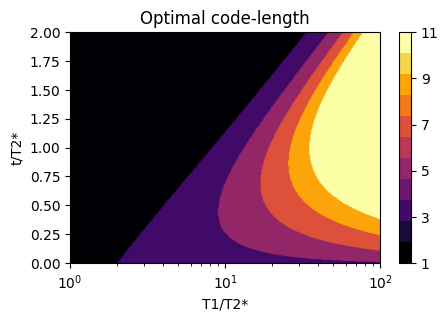

In [56]:
cmap = plt.get_cmap('inferno', np.max(DAT) - np.min(DAT) + 1)

plt.figure(figsize=(5,3))
plt.ylabel("t/T2*")
plt.xlabel("T1/T2*")
plt.title('Optimal code-length')
plt.pcolormesh(T1ran,tran,DAT, cmap=cmap, shading='gouraud')
plt.colorbar(ticks=np.arange(np.min(DAT), np.max(DAT) + 1,2))
ax=plt.gca()
ax.set_xscale('log')
#ax.set_aspect('equal')
